# 필요 package

In [5]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import os
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

from selenium import webdriver as wd
import time
from bs4 import BeautifulSoup
import requests
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor

import seaborn as sns
import geopy.distance

# 크롤링 코드

In [ ]:
browser = wd.Chrome("../../software/chromedriver.exe")
browser.get("https://www.airport.co.kr/jeju/extra/flightSchedule/flightDomesticList/layOut.do?cid=2015120718125215729&menuId=653")

element = browser.find_element_by_xpath('//*[@id="selType"]')
element.click()

element = browser.find_element_by_xpath('//*[@id="selType"]/option[2]')
element.click()

element = browser.find_element_by_xpath('//*[@id="findDate"]')
element.clear()
element.send_keys("2019-10-27")

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[2]/form/div/div[2]/button')
element.click()

air_head = []

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/thead')

for i in range(1, 264):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
for i in range(1, 272):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[4]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
test = pd.DataFrame(data = air_content, columns = air_head)

test["제주 관련 시간"] = 0
test["제주 시간 관련"] = 0

for i in range(len(test)):
    if test["출발지"][i] == "제주":
        test["제주 관련 시간"][i] = test["출발시간"][i]
    else:
        test["제주 관련 시간"][i] = test["도착시간"][i]
        
test.drop("편명", axis = 1, inplace = True)

test.to_csv("../data/result_air.csv")

# 데이터 불러오기

In [6]:
# 데이터 불러오기
bus_df = pd.read_csv("bus_train_data.csv")
weather_df = pd.read_csv("jeju_weather.csv")
air_df = pd.read_csv("result_air.csv")

In [7]:
weather_df["date"] = "date"

In [8]:
for i in range(len(weather_df["date_group"])):
    weather_df["date"][i] = weather_df["date_group"][i].replace("일", "")
    weather_df["date"][i] = "2019-10-{0}".format(weather_df["date"][i])
    
weather_df = weather_df.rename(columns = {"time_group" : "now_arrive_time"})
weather_df = weather_df.drop(weather_df.columns[[0,2,5,7,8,9,10,11]],  axis = 1)

bus_weather_df = pd.merge(bus_df, weather_df)

In [9]:
temp = air_df.groupby(["날짜", "시간"]).count()
temp = pd.DataFrame(temp["항공사"].unstack())

data_list = []

for i in range(len(temp.index)):
    for j in range(len(temp.columns)):
        data_list.append([temp.index[i],temp.columns[j], temp.iloc[i][j]])
        
air_df = pd.DataFrame(data_list)

air_df.columns = ["date", "now_arrive_time", "count_air"]

df = pd.merge(bus_weather_df, air_df)

train = df

# 데이터 전처리

In [10]:
# 날짜 전처리
train['date_group']='weekday' #date_group 변수를 미리 생성

train.loc[ (train['date'] == '2019-10-19') | (train['date'] == '2019-10-20') | (train['date'] == '2019-10-26') | (train['date'] == '2019-10-27') ,['date_group'] ]= 'weekend' # 주말
train = pd.get_dummies(train,columns=['date_group'])

# 19, 20, 26, 27

<BarContainer object of 2 artists>

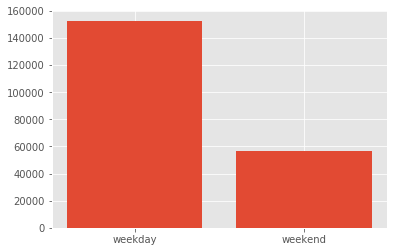

In [11]:
label = ['weekday', 'weekend']
plt.bar(label, [(train['date_group_weekday'] == 1).sum(), (train['date_group_weekday'] == 0).sum()])

In [12]:
train["date_day"] = "monday"
train.loc[(train["date"] == "2019-10-15") | (train["date"] == "2019-10-22"), ["date_day"]] = "Tuesday"
train.loc[(train["date"] == "2019-10-16") | (train["date"] == "2019-10-23"), ["date_day"]] = "Wednesday"
train.loc[(train["date"] == "2019-10-17") | (train["date"] == "2019-10-24"), ["date_day"]] = "Thurday"
train.loc[(train["date"] == "2019-10-18") | (train["date"] == "2019-10-25"), ["date_day"]] = "Friday"
train.loc[(train["date"] == "2019-10-19") | (train["date"] == "2019-10-26"), ["date_day"]] = "Saturday"
train.loc[(train["date"] == "2019-10-20") | (train["date"] == "2019-10-27"), ["date_day"]] = "Sunday"

train = pd.get_dummies(train, columns=["date_day"])

<BarContainer object of 7 artists>

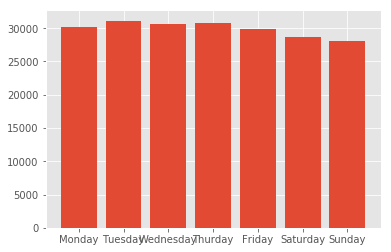

In [13]:
label = ["Monday", "Tuesday", "Wednesday", "Thurday", "Friday", "Saturday", "Sunday"]
plt.bar(label, [(train["date_day_monday"] == 1).sum(),(train["date_day_Tuesday"] == 1).sum(),(train["date_day_Wednesday"] == 1).sum(),(train["date_day_Thurday"] == 1).sum(),(train["date_day_Friday"] == 1).sum(),(train["date_day_Saturday"] == 1).sum(),(train["date_day_Sunday"] == 1).sum()])

In [14]:
# 강수량 전처리
train['rain']=0
train.loc[ (train['누적강수량(mm)']!=0) ,['rain'] ] = 1

In [15]:
# 시간 전처리
train['time_group']='group' #time_group 변수를 미리 생성

train.loc[ (train['now_arrive_time']>='05시') & (train['now_arrive_time']<='06시') ,['time_group'] ]= 'dawn' # 05~06시
train.loc[ (train['now_arrive_time']>='07시') & (train['now_arrive_time']<='08시') ,['time_group'] ]= 'morning' #07~08시
train.loc[ (train['now_arrive_time']>='09시') & (train['now_arrive_time']<='17시') ,['time_group'] ]= 'afternoon' #09~17시
train.loc[ (train['now_arrive_time']=='18시') ,['time_group'] ]= 'dinner' #18시
train.loc[ (train['now_arrive_time']>='19시') & (train['now_arrive_time']<='22시') ,['time_group'] ]= 'night' #09~17시

train = pd.get_dummies(train,columns=['time_group'])

In [16]:
# 풍속
w = pd.DataFrame(train['풍속(m/s)'].groupby([train['date'],train['now_arrive_time']]).mean())
train['wind'] = 0
train.loc[(train['풍속(m/s)'] > w.mean()[0]) ,['wind']] = 1

<BarContainer object of 2 artists>

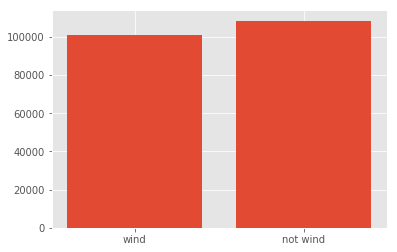

In [17]:
label = ['wind', 'not wind']
plt.bar(label, [(train["wind"] == 1).sum(),(train["wind"] == 0).sum()])

In [18]:
temp_list = []
train = train.drop(train[train["next_arrive_time"] > 1000].index)
max = train.distance.max()
min = train.distance.min()

for i in train.distance:
    temp_list.append((i - min) / (max - min))
train.distance = temp_list

In [19]:
temp_list = []

max = train.count_air.max()
min = train.count_air.min()

for i in train.count_air:
    temp_list.append((i - min) / (max - min))
train.count_air = temp_list

In [17]:
train['distance_line']=[ geopy.distance.vincenty( (i,j), (k,l) ).km 
 for i,j,k,l in list( zip( train['now_latitude'],train['now_longitude'],train['next_latitude'],train['next_longitude'] ) ) ]

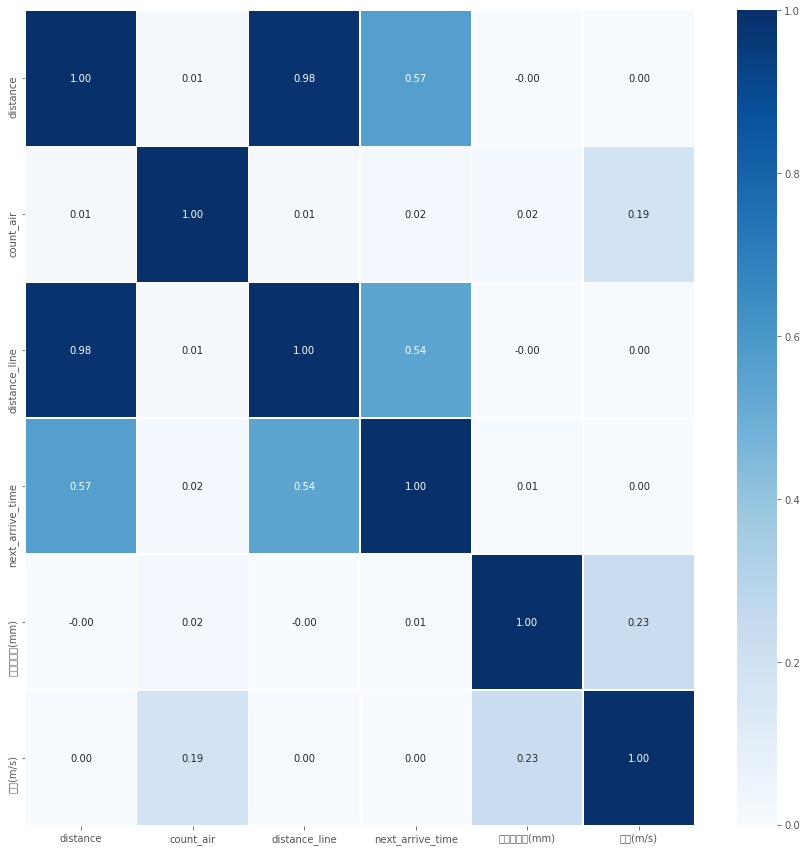

In [18]:
data = (pd.DataFrame([train["distance"],train["count_air"],train["distance_line"],train["next_arrive_time"],train["누적강수량(mm)"], train["풍속(m/s)"]]).T).corr()

plt.figure(figsize=(15,15))
sns.heatmap(data =data, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [19]:
train = train.drop(train[["누적강수량(mm)", "풍속(m/s)"]], axis = "columns")
train.rename(columns = {"기온(°C)": "Temp(°C)"}, inplace=True)

In [26]:
train.to_csv('s.csv', encoding='UTF-8')

In [22]:
train.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,기온(°C),누적강수량(mm),풍속(m/s),count_air,date_group_weekday,date_group_weekend,date_day_Friday,date_day_Saturday,date_day_Sunday,date_day_Thurday,date_day_Tuesday,date_day_Wednesday,date_day_monday,rain,time_group_afternoon,time_group_dawn,time_group_dinner,time_group_morning,time_group_night,wind
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,0.022949,제대마을,33.457724,126.554014,24,15.526667,0.0,1.706667,0.055556,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,0.032048,제대아파트,33.458783,126.557353,36,15.526667,0.0,1.706667,0.055556,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,0.043183,제주대학교,33.459893,126.561624,40,15.526667,0.0,1.706667,0.055556,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,0.065318,제주여자중고등학교(아라방면),33.484860,126.542928,42,15.526667,0.0,1.706667,0.055556,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,181,2019-10-15,405136001,7997034,360-1,33.484860,126.542928,제주여자중고등학교(아라방면),06시,0.065318,남국원(아라방면),33.479705,126.543811,92,15.526667,0.0,1.706667,0.055556,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


# 데이터 학습 및 예측

In [21]:
train_x = train.drop(train[["id", "date","route_id", "vh_id", "route_nm", "now_latitude", "now_longitude", "now_station", "now_arrive_time", "next_station", "next_arrive_time", "next_latitude", "next_longitude"]], axis = "columns")
train_y = train.next_arrive_time

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [23]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X=X_train, y=y_train)
prediction = linear_regression.predict(X = pd.DataFrame(X_test))
print('{0}: a value = '.format(i), linear_regression.intercept_)
print('{0}: b value = '.format(i), linear_regression.coef_)
print(prediction)
print((mean_squared_error(prediction, y_test))**0.5)

3: a value =  70.23179909015978
3: b value =  [ 1.15973349e+03 -1.87640831e-01  8.47834862e+00  1.00706231e+00
 -1.00706231e+00  8.79515159e-01  5.30777537e-01 -1.53783985e+00
 -1.46086026e-01 -3.75434403e-01  4.63078644e-01  1.85988939e-01
  7.68186951e-01 -2.66888447e+00  3.14256848e+00  4.85409482e+00
 -1.65779885e+00 -3.66997998e+00 -7.57696462e-01 -1.06760819e+02]
[79.18739273 72.76133124 75.52032076 ... 75.80764276 74.83958798
 63.74006018]
53.86053602809004


In [24]:
rf = RandomForestRegressor(random_state=1217)
rf.fit(X_train,y_train)
result = 0
predict = rf.predict(X_test)
print((mean_squared_error(predict, y_test))**0.5)

40.33633031301527


In [25]:
gbrt = GradientBoostingRegressor(max_depth=3, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 9999):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print((val_error)**0.5)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

63.658183968794496
61.48092269229119
59.73136447589642
58.15074867555899
56.83152189798726
55.80157641955654
54.8394445563949
53.987226738604555
53.26241912710922
52.62191974609214
52.131381201785224
51.6748558287462
51.26659597467782
50.924835725442115
50.652549447332774
50.393123845306896
50.1785078848625
49.95460089184687
49.768114662343905
49.58723937532192
49.400907146842584
49.22149833467268
49.11845002474907
48.92745917433286
48.845875575797336
48.71410187292423
48.60830239316494
48.22284356809151
48.14703326822488
47.84507431099209
47.69675731428827
47.65729312935968
47.43498289278527
47.327276335163326
47.30572532741441
47.1986041905354
46.93766738873418
46.86869323130883
46.80661825576909
46.708884058301614
46.62687834142703
46.60983868636365
46.512438666888315
46.44228201727367
46.42868851857019
46.41445298843679
46.33954883323208
46.22333972646335
46.10015945931745
46.0315881657664
45.98327725300822
45.97403324653482
45.87301508854418
45.67871244450725
45.65518507929394
45.

38.143729540335315
38.14136735266102
38.14090132836431
38.13619313733533
38.131072779128466
38.12944718059029
38.12279759719056
38.11609885795521
38.1026067491782
38.10271115513743
38.09209414500134
38.092196909703134
38.07814314686705
38.07060153656361
38.06188504617341
38.05851281566801
38.0576949351785
38.05225869875778
38.05098916095118
38.04831118699854
38.03601438068729
38.03195323419739
38.02797457922622
38.01995411320679
38.01983354407948
38.01614208409176
38.01436933484667
38.01342718417148
38.00839863844362
38.00415676842083
37.99279567132171
37.988985806670215
37.98216480136586
37.98010956778835
37.978836522392406
37.96551103164044
37.95967553531535
37.95399393383406
37.95011769359338
37.945558956208075
37.94183350502205
37.92755859519298
37.92696479526779
37.921991857652735
37.91427325790835
37.9094001696225
37.90880687708206
37.908988706655144
37.90405637531794
37.90366041088779
37.89957747743413
37.899477188763214
37.894685128335816
37.89399355112074
37.89317043395181
37.

36.857005853488694
36.856725736271244
36.85720055796296
36.85601343631985
36.85504952626285
36.854908439311686
36.85436690926464
36.8529715247943
36.852631076275266
36.85321779588865
36.85290654787452
36.85245643817446
36.852800298945255
36.850721640212335
36.846326195078504
36.84423333362561
36.842560597207374
36.84034080454863
36.83927225859201
36.838862670054766
36.83866713971266
36.83744905959443
36.83561324474823
36.835083476488165
36.83311423335388
36.833007017697845
36.83158008065293
36.826682668295376
36.825260667652174
36.82407320869765
36.82310457055444
36.82113722564619
36.81887556001254
36.81654126242634
36.81504910197529
36.81309159467493
36.8123079910705
36.810021042934416
36.80953176462195
36.80593262550834
36.80525915700681
36.80425984882604
36.804211430795036
36.80213191431944
36.80094886561089
36.800594317590146
36.800061652482285
36.79980581164662
36.79750333067768
36.79622041325183
36.79559194831317
36.79510665424156
36.79511065545122
36.79416883366422
36.7934766056

36.47198675190248
36.47140484619684
36.4700185617008
36.467819129469454
36.46739037130351
36.467115778859664
36.466626757701604
36.465318616492716
36.46470825014878
36.4633854477048
36.46474799288722
36.46357538165858
36.46349979196822
36.463583664588114
36.462932867771926
36.4629502096456
36.46295444350399
36.462751838511416
36.46053654685114
36.4604650013091
36.46010422089453
36.459728200386834
36.45943054475827
36.459274998042325
36.45840274612474
36.45819580201428
36.45788003372579
36.45672712579627
36.45604316861288
36.455439602144054
36.4549451227333
36.45476476443137
36.454515131558146
36.45477368226616
36.454382200082044
36.45440375403155
36.45446899357869
36.45436547429905
36.45381107705731
36.45339632608928
36.45269204757859
36.45282104769574
36.452490410742634
36.45407909652454
36.45358711710744
36.45359611586282
36.45294779662255
36.452738751453055


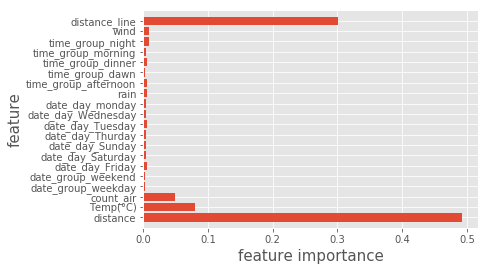

In [26]:
n_feature = train_x.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

input_var= list( train_x.columns[:] )
plt.barh(index, rf.feature_importances_, align='center') 
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()